In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils

In [9]:
# =======================================
# 1. HYPERPARAMETERS
# =======================================
dataroot = "/kaggle/input/five-classes/Class" 
batch_size = 16
image_size = 64
nz = 100      # Size of latent vector (z)
ngf = 64      # Generator feature maps
ndf = 64      # Discriminator feature maps
num_epochs = 20
lr = 0.0002
beta1 = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# ----------------------------
# Dataset & Dataloader
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]
])

dataset = datasets.ImageFolder(root=dataroot, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

nc = 3  # number of channels (RGB)

In [11]:
# ----------------------------
# Generator
# ----------------------------
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: Z latent vector
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()  # Output: [-1, 1]
        )

    def forward(self, x):
        return self.main(x)

In [12]:
# ----------------------------
# Discriminator (Fixed)
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)

In [13]:
# ----------------------------
# Initialize models
# ----------------------------
netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [14]:
# ----------------------------
# Training Loop
# ----------------------------
print("Starting Training...")
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # --------------------
        # Train Discriminator
        # --------------------
        netD.zero_grad()
        real_images = real_images.to(device)
        b_size = real_images.size(0)

        label = torch.full((b_size,), 1.0, dtype=torch.float, device=device)
        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()

        # Fake data
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(0.0)
        output = netD(fake_images.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()

        optimizerD.step()

        # --------------------
        # Train Generator
        # --------------------
        netG.zero_grad()
        label.fill_(1.0)  # Generator wants discriminator to output "real"
        output = netD(fake_images)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        if i % 20 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {errD_real+errD_fake:.4f} Loss_G: {errG:.4f}")

    # Save generated images for inspection after each epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    vutils.save_image(fake, f"epoch_{epoch:03d}.png", normalize=True)

Starting Training...
[0/20][0/62] Loss_D: 1.3619 Loss_G: 3.7745
[0/20][20/62] Loss_D: 0.0262 Loss_G: 7.0171
[0/20][40/62] Loss_D: 0.0109 Loss_G: 12.9515
[0/20][60/62] Loss_D: 0.0880 Loss_G: 11.3737
[1/20][0/62] Loss_D: 0.0127 Loss_G: 10.4919
[1/20][20/62] Loss_D: 0.1831 Loss_G: 17.4453
[1/20][40/62] Loss_D: 0.0848 Loss_G: 11.6718
[1/20][60/62] Loss_D: 0.0001 Loss_G: 16.7357
[2/20][0/62] Loss_D: 0.0007 Loss_G: 9.1655
[2/20][20/62] Loss_D: 0.0092 Loss_G: 13.6019
[2/20][40/62] Loss_D: 0.1658 Loss_G: 8.1161
[2/20][60/62] Loss_D: 0.0933 Loss_G: 14.5420
[3/20][0/62] Loss_D: 0.0027 Loss_G: 8.9387
[3/20][20/62] Loss_D: 0.0150 Loss_G: 9.3966
[3/20][40/62] Loss_D: 0.0649 Loss_G: 9.4153
[3/20][60/62] Loss_D: 0.0151 Loss_G: 10.9178
[4/20][0/62] Loss_D: 0.0285 Loss_G: 6.5459
[4/20][20/62] Loss_D: 0.4415 Loss_G: 20.3395
[4/20][40/62] Loss_D: 0.0825 Loss_G: 25.4864
[4/20][60/62] Loss_D: 0.0151 Loss_G: 13.8008
[5/20][0/62] Loss_D: 0.0026 Loss_G: 10.4015
[5/20][20/62] Loss_D: 0.2510 Loss_G: 14.3455
[5/

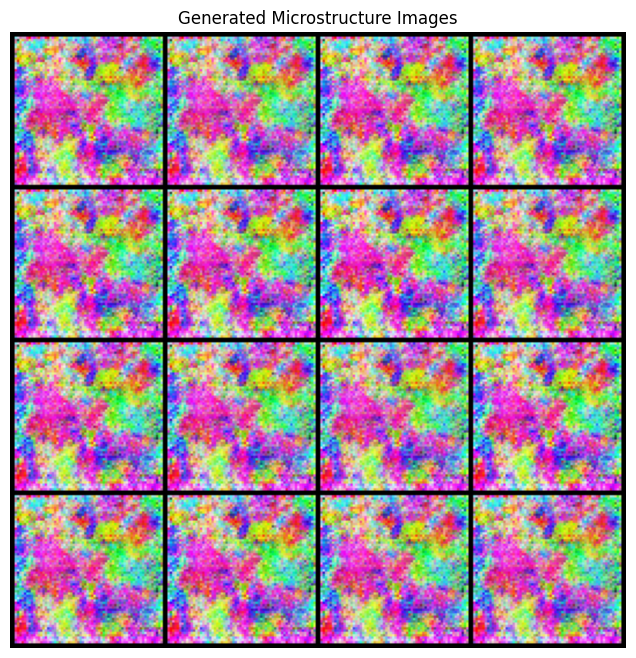

In [19]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Assuming netG is your trained generator and nz is latent dimension
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained generator weights
netG.eval()  # set to evaluation mode

# Generate random latent vector (batch of 16 images)
num_images = 16
noise = torch.randn(num_images, nz, 1, 1, device=device)

with torch.no_grad():
    fake_images = netG(noise).detach().cpu()

# Save generated images as a grid
grid = vutils.make_grid(fake_images, nrow=4, normalize=True)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Microstructure Images")
plt.imshow(grid.permute(1, 2, 0))
plt.show()
